In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [ ]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [ ]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [ ]:
# train/validation/test 분리 함수 (시계열 데이터용, 6:2:2 비율)
def split_train_val_test(df):
    n = len(df)

    # 데이터셋 크기 계산
    train_end = int(0.6 * n)
    val_end = int(0.8 * n)  # 0.6 + 0.2

    # 순차적으로 데이터 분할
    train_data = df[:train_end]     # 처음 60%는 train 데이터
    val_data = df[train_end:val_end] # 그 다음 20%는 validation 데이터
    test_data = df[val_end:]        # 마지막 20%는 test 데이터

    # 데이터 크기 출력 (원한다면)
    # print("Train set:", train_data.shape)
    # print("Validation set:", val_data.shape)
    # print("Test set:", test_data.shape)

    return train_data, val_data, test_data

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [ ]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 성능 테스트 함수

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation(y_test, y_pred):

    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # MAE (Mean Absolute Error) 계산
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # 예측 결과와 실제 값을 비교하는 샘플 출력
    for i in range(5):  # 예시로 첫 5개만 출력
        print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

## 전처리

### 1. 데이터셋 가져오기

In [ ]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/drive/MyDrive/deep-uav/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [ ]:
df = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lat'])
new_x, lon = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lon'])
new_x, alt = spline_interpolation(df['Timpstemp'] / 1e6 , df[' alt'])

df = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

df = truncation(df)
scaler, df = min_max_scaling(df)

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- GRU를 사용한 모델 클래스 선언
- 구조 : GRU + Fully Connected Layer

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 하이퍼파라미터와 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력만 사용
        return out

In [ ]:
# Optuna의 목적 함수 정의
def objective(trial, df, sequence_length):
    # 하이퍼파라미터 탐색 범위
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units_l0 = trial.suggest_int('n_units_l0', 32, 128)
    # dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 64)

    # 메인 코드
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size, sequence_length)

    # 첫 번째 배치를 가져와 input_size, output_size 계산
    first_batch = next(iter(train_loader))
    X_train_batch, y_train_batch = first_batch
    input_size = X_train_batch.shape[2]  # 입력 데이터의 feature 크기
    output_size = y_train_batch.shape[1]  # 예측할 값의 크기

    early_stopping_patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 모델 및 데이터 설정
    model = GRUModel(input_size, n_units_l0, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    for epoch in range(300):
        train_loss = train_model(model, criterion, optimizer, train_loader, device)
        val_loss, _, _ = evaluate_model(model, criterion, val_loader, device)

        # Early Stopping 조건 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # 개선되면 카운터 초기화
        else:
            patience_counter += 1  # 개선되지 않으면 카운터 증가

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optuna에 학습 결과 보고
        trial.report(val_loss, epoch)

        # Pruning: 성능이 개선되지 않으면 중단
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

In [ ]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, loader, device, history):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    # history가 주어지면 학습 손실 기록
    if history is not None:
        history['train_loss'].append(avg_loss)

    return avg_loss

In [ ]:
# 검증 및 테스트 함수
def evaluate_model(model, criterion, loader, device, history):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    start_time = time.time()  # 예측 시작 시간 기록

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    end_time = time.time()  # 예측 종료 시간 기록
    total_inference_time = end_time - start_time

    print(f"Total Inference Time: {total_inference_time:.2f} seconds")

    avg_loss = total_loss / len(loader)

    # history가 주어지면 검증 손실 기록
    if history is not None:
        history['val_loss'].append(avg_loss)

    return avg_loss, true_values, predictions

## 학습

### 1. 데이터 준비

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

In [ ]:
# 데이터 로더 생성 함수
def prepare_dataloader(df, batch_size, sequence_length, look_back=10, forward=0):

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(df)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back, forward)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back, forward)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back, forward)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [ ]:
sequence_length = 10

#### 1. early stopping 함수 선언

In [ ]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(lambda trial: objective(trial, df, sequence_length), n_trials=100)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-07 07:20:51,959] A new study created in memory with name: no-name-a0bc2abf-f2c9-4fb2-8174-27ccaed8019e
<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time

[I 2024-10-07 07:21:29,504] Trial 0 finished with value: 6.256714100345561e-05 and parameters: {'n_layers': 1, 'n_units_l0': 99, 'learning_rate': 0.0005594828220256459, 'batch_size': 55}. Best is trial 0 with value: 6.256714100345561e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 51


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.16 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time

[I 2024-10-07 07:22:57,256] Trial 1 finished with value: 2.2835655158814916e-05 and parameters: {'n_layers': 2, 'n_units_l0': 117, 'learning_rate': 0.004672969233503039, 'batch_size': 34}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.14 seconds
Early stopping at epoch 41


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 07:24:27,168] Trial 2 finished with value: 2.9956919333659136e-05 and parameters: {'n_layers': 1, 'n_units_l0': 96, 'learning_rate': 0.00033020562583025717, 'batch_size': 16}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.10 seconds
Early stopping at epoch 61


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.11 seconds
Total Inference Time

[I 2024-10-07 07:26:01,827] Trial 3 finished with value: 3.726166091332238e-05 and parameters: {'n_layers': 3, 'n_units_l0': 65, 'learning_rate': 0.002363342258943787, 'batch_size': 63}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.17 seconds
Early stopping at epoch 66


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 07:27:17,143] Trial 4 finished with value: 3.868903526280418e-05 and parameters: {'n_layers': 3, 'n_units_l0': 49, 'learning_rate': 0.003331213068031604, 'batch_size': 62}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.14 seconds
Early stopping at epoch 62


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds


[I 2024-10-07 07:27:30,005] Trial 5 pruned. 


Total Inference Time: 0.10 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 07:27:44,052] Trial 6 pruned. 


Total Inference Time: 0.08 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time

[I 2024-10-07 07:29:04,517] Trial 7 finished with value: 3.101422569468721e-05 and parameters: {'n_layers': 2, 'n_units_l0': 105, 'learning_rate': 0.0007710805964654169, 'batch_size': 60}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.17 seconds
Early stopping at epoch 52


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.13 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds


[I 2024-10-07 07:29:38,408] Trial 8 finished with value: 3.162099091645764e-05 and parameters: {'n_layers': 2, 'n_units_l0': 82, 'learning_rate': 0.009139940660239371, 'batch_size': 60}. Best is trial 1 with value: 2.2835655158814916e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 27


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds


[I 2024-10-07 07:29:44,266] Trial 9 pruned. 


Total Inference Time: 0.04 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.17 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.28 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.28 seconds
Total Inference Time: 0.31 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:30:44,321] Trial 10 finished with value: 2.240945314145971e-05 and parameters: {'n_layers': 2, 'n_units_l0': 124, 'learning_rate': 0.00943598681913609, 'batch_size': 25}. Best is trial 10 with value: 2.240945314145971e-05.


Total Inference Time: 0.18 seconds
Early stopping at epoch 22


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.18 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.31 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.20 seconds


[I 2024-10-07 07:31:47,571] Trial 11 finished with value: 2.5110445979710978e-05 and parameters: {'n_layers': 2, 'n_units_l0': 127, 'learning_rate': 0.009752854483896312, 'batch_size': 24}. Best is trial 10 with value: 2.240945314145971e-05.


Total Inference Time: 0.18 seconds
Early stopping at epoch 22


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.25 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds


[I 2024-10-07 07:32:45,000] Trial 12 finished with value: 2.2745708313529825e-05 and parameters: {'n_layers': 2, 'n_units_l0': 121, 'learning_rate': 0.0048183421449610585, 'batch_size': 33}. Best is trial 10 with value: 2.240945314145971e-05.


Total Inference Time: 0.15 seconds
Early stopping at epoch 25


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.15 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time

[I 2024-10-07 07:34:39,672] Trial 13 finished with value: 2.194258301339384e-05 and parameters: {'n_layers': 2, 'n_units_l0': 125, 'learning_rate': 0.0016741811859466783, 'batch_size': 33}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.17 seconds
Early stopping at epoch 49


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.21 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.33 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.34 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.20 seconds


[I 2024-10-07 07:35:20,429] Trial 14 pruned. 


Total Inference Time: 0.31 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds


[I 2024-10-07 07:35:29,367] Trial 15 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.21 seconds
Total Inference Time: 0.34 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.35 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.35 seconds


[I 2024-10-07 07:36:09,233] Trial 16 pruned. 


Total Inference Time: 0.22 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds


[I 2024-10-07 07:36:22,879] Trial 17 pruned. 


Total Inference Time: 0.14 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds


[I 2024-10-07 07:36:50,666] Trial 18 pruned. 


Total Inference Time: 0.24 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds


[I 2024-10-07 07:37:17,311] Trial 19 pruned. 


Total Inference Time: 0.15 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.22 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds


[I 2024-10-07 07:37:46,145] Trial 20 pruned. 


Total Inference Time: 0.15 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.23 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.28 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:38:28,695] Trial 21 finished with value: 3.5024945873374236e-05 and parameters: {'n_layers': 2, 'n_units_l0': 127, 'learning_rate': 0.005154121657757881, 'batch_size': 34}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.18 seconds
Early stopping at epoch 17


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.28 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:39:31,085] Trial 22 finished with value: 3.094874536869536e-05 and parameters: {'n_layers': 2, 'n_units_l0': 117, 'learning_rate': 0.006501944961092027, 'batch_size': 22}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.17 seconds
Early stopping at epoch 22


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds


[I 2024-10-07 07:40:17,098] Trial 23 finished with value: 3.0410944622542895e-05 and parameters: {'n_layers': 2, 'n_units_l0': 122, 'learning_rate': 0.0038967257436524493, 'batch_size': 38}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.16 seconds
Early stopping at epoch 21


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time

[I 2024-10-07 07:41:27,901] Trial 24 finished with value: 2.37502795113999e-05 and parameters: {'n_layers': 2, 'n_units_l0': 103, 'learning_rate': 0.006944200278062527, 'batch_size': 31}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.13 seconds
Early stopping at epoch 34


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.26 seconds
Total Inference Time: 0.31 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds


[I 2024-10-07 07:42:04,353] Trial 25 pruned. 


Total Inference Time: 0.18 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 07:42:16,745] Trial 26 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.16 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.16 seconds


[I 2024-10-07 07:42:49,768] Trial 27 pruned. 


Total Inference Time: 0.16 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.14 seconds


[I 2024-10-07 07:43:08,943] Trial 28 pruned. 


Total Inference Time: 0.15 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds


[I 2024-10-07 07:43:24,249] Trial 29 pruned. 


Total Inference Time: 0.14 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.17 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds


[I 2024-10-07 07:43:48,261] Trial 30 pruned. 


Total Inference Time: 0.13 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.16 seconds
Total Inference Time: 0.24 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds


[I 2024-10-07 07:44:33,390] Trial 31 finished with value: 2.441473362951536e-05 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'learning_rate': 0.00441996305734182, 'batch_size': 32}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.17 seconds
Early stopping at epoch 20


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.21 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.29 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.27 seconds


[I 2024-10-07 07:45:42,418] Trial 32 finished with value: 2.3047826376708916e-05 and parameters: {'n_layers': 2, 'n_units_l0': 127, 'learning_rate': 0.005598645947113111, 'batch_size': 28}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.18 seconds
Early stopping at epoch 24


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:46:27,626] Trial 33 finished with value: 3.217701628429871e-05 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'learning_rate': 0.002479267469912599, 'batch_size': 38}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.20 seconds
Early stopping at epoch 27


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.22 seconds
Total Inference Time

[I 2024-10-07 07:47:45,419] Trial 34 finished with value: 2.925622960571094e-05 and parameters: {'n_layers': 2, 'n_units_l0': 113, 'learning_rate': 0.001646599019385786, 'batch_size': 33}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.14 seconds
Early stopping at epoch 37


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.32 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.33 seconds
Total Inference Time: 0.35 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.32 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.32 seconds
Total Inference Time: 0.34 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.35 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.20 seconds
Total Inference Time

[I 2024-10-07 07:50:21,903] Trial 35 finished with value: 2.5559754741758905e-05 and parameters: {'n_layers': 3, 'n_units_l0': 122, 'learning_rate': 0.0036655418829205587, 'batch_size': 46}. Best is trial 13 with value: 2.194258301339384e-05.


Total Inference Time: 0.20 seconds
Early stopping at epoch 55


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.20 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.21 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.14 seconds


[I 2024-10-07 07:50:46,135] Trial 36 pruned. 


Total Inference Time: 0.14 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds


[I 2024-10-07 07:51:01,141] Trial 37 pruned. 


Total Inference Time: 0.09 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.17 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.22 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.23 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.25 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.15 seconds


[I 2024-10-07 07:51:49,703] Trial 38 finished with value: 2.1771423055389804e-05 and parameters: {'n_layers': 2, 'n_units_l0': 116, 'learning_rate': 0.009999329966483532, 'batch_size': 29}. Best is trial 38 with value: 2.1771423055389804e-05.


Total Inference Time: 0.15 seconds
Early stopping at epoch 21


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.18 seconds
Total Inference Time: 0.30 seconds
Total Inference Time: 0.19 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.20 seconds
Total Inference Time: 0.27 seconds
Total Inference Time: 0.32 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:52:26,299] Trial 39 pruned. 


Total Inference Time: 0.31 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time

[I 2024-10-07 07:53:13,489] Trial 40 finished with value: 2.1215757252927386e-05 and parameters: {'n_layers': 1, 'n_units_l0': 108, 'learning_rate': 0.007972298191551102, 'batch_size': 30}. Best is trial 40 with value: 2.1215757252927386e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 43


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 07:53:37,538] Trial 41 finished with value: 2.508785325971985e-05 and parameters: {'n_layers': 1, 'n_units_l0': 115, 'learning_rate': 0.007887129727376572, 'batch_size': 29}. Best is trial 40 with value: 2.1215757252927386e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 21


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 07:54:03,908] Trial 42 finished with value: 2.900008464873988e-05 and parameters: {'n_layers': 1, 'n_units_l0': 108, 'learning_rate': 0.005706439228229932, 'batch_size': 30}. Best is trial 40 with value: 2.1215757252927386e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 23


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 07:54:30,854] Trial 43 finished with value: 2.303525593561062e-05 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'learning_rate': 0.008008407937902182, 'batch_size': 37}. Best is trial 40 with value: 2.1215757252927386e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 25


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 07:55:07,722] Trial 44 finished with value: 1.7573821537553158e-05 and parameters: {'n_layers': 1, 'n_units_l0': 123, 'learning_rate': 0.00906128818560354, 'batch_size': 27}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.12 seconds
Early stopping at epoch 29


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds


[I 2024-10-07 07:55:39,311] Trial 45 finished with value: 2.2357335414933634e-05 and parameters: {'n_layers': 1, 'n_units_l0': 116, 'learning_rate': 0.009921511106924377, 'batch_size': 21}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.16 seconds
Early stopping at epoch 21


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.13 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 07:56:09,476] Trial 46 finished with value: 2.1042881104886663e-05 and parameters: {'n_layers': 1, 'n_units_l0': 77, 'learning_rate': 0.009840923045449096, 'batch_size': 21}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.13 seconds
Early stopping at epoch 24


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.15 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.18 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time

[I 2024-10-07 07:57:20,522] Trial 47 finished with value: 2.059462726619773e-05 and parameters: {'n_layers': 1, 'n_units_l0': 76, 'learning_rate': 0.007335125944838542, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 47


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 07:58:04,602] Trial 48 finished with value: 1.7674232161368764e-05 and parameters: {'n_layers': 1, 'n_units_l0': 76, 'learning_rate': 0.0070403089664349385, 'batch_size': 17}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 31


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.17 seconds


[I 2024-10-07 07:58:43,912] Trial 49 finished with value: 2.1888561136051976e-05 and parameters: {'n_layers': 1, 'n_units_l0': 79, 'learning_rate': 0.007537650067479177, 'batch_size': 17}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 27


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 07:59:33,901] Trial 50 finished with value: 2.0315332449172274e-05 and parameters: {'n_layers': 1, 'n_units_l0': 59, 'learning_rate': 0.006163539322481507, 'batch_size': 18}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 41


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:00:03,945] Trial 51 finished with value: 2.3191370677235873e-05 and parameters: {'n_layers': 1, 'n_units_l0': 60, 'learning_rate': 0.006098323025432961, 'batch_size': 19}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 25


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:00:24,076] Trial 52 finished with value: 3.209262331438367e-05 and parameters: {'n_layers': 1, 'n_units_l0': 75, 'learning_rate': 0.00798778687572048, 'batch_size': 18}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.12 seconds
Early stopping at epoch 15


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:01:14,103] Trial 53 finished with value: 1.8614899049751443e-05 and parameters: {'n_layers': 1, 'n_units_l0': 67, 'learning_rate': 0.004269645427963378, 'batch_size': 17}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 37


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:02:02,235] Trial 54 finished with value: 1.825682814422394e-05 and parameters: {'n_layers': 1, 'n_units_l0': 65, 'learning_rate': 0.004030457899857538, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 35


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time

[I 2024-10-07 08:02:59,646] Trial 55 finished with value: 1.8213745356794843e-05 and parameters: {'n_layers': 1, 'n_units_l0': 66, 'learning_rate': 0.002912565651175035, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 41


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:03:15,898] Trial 56 pruned. 


Total Inference Time: 0.08 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time

[I 2024-10-07 08:04:16,939] Trial 57 finished with value: 1.781320418772606e-05 and parameters: {'n_layers': 1, 'n_units_l0': 69, 'learning_rate': 0.004002175579349033, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 44


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time

[I 2024-10-07 08:05:01,096] Trial 58 finished with value: 1.87769804206121e-05 and parameters: {'n_layers': 1, 'n_units_l0': 66, 'learning_rate': 0.003996890739839834, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 32


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:05:11,409] Trial 59 pruned. 


Total Inference Time: 0.10 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.06 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:05:21,824] Trial 60 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds


[I 2024-10-07 08:05:59,731] Trial 61 finished with value: 2.063517983769463e-05 and parameters: {'n_layers': 1, 'n_units_l0': 68, 'learning_rate': 0.0038123836834341777, 'batch_size': 16}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 26


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:06:58,382] Trial 62 finished with value: 1.7912819753531183e-05 and parameters: {'n_layers': 1, 'n_units_l0': 66, 'learning_rate': 0.004261536747277039, 'batch_size': 19}. Best is trial 44 with value: 1.7573821537553158e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 49


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:08:01,785] Trial 63 finished with value: 1.709196305489092e-05 and parameters: {'n_layers': 1, 'n_units_l0': 55, 'learning_rate': 0.004934624328150984, 'batch_size': 20}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 58


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:08:32,758] Trial 64 finished with value: 2.1868315562406444e-05 and parameters: {'n_layers': 1, 'n_units_l0': 54, 'learning_rate': 0.004963846327586208, 'batch_size': 20}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 28


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:09:02,503] Trial 65 finished with value: 2.6657669487966424e-05 and parameters: {'n_layers': 1, 'n_units_l0': 84, 'learning_rate': 0.002910631866855668, 'batch_size': 22}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 25


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 08:09:37,774] Trial 66 finished with value: 2.2075582197239303e-05 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'learning_rate': 0.005121541034135486, 'batch_size': 19}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.11 seconds
Early stopping at epoch 29


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:09:50,652] Trial 67 pruned. 


Total Inference Time: 0.08 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.06 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds


[I 2024-10-07 08:10:00,822] Trial 68 pruned. 


Total Inference Time: 0.06 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:10:49,404] Trial 69 finished with value: 1.9863629058993236e-05 and parameters: {'n_layers': 1, 'n_units_l0': 63, 'learning_rate': 0.003411182345270383, 'batch_size': 21}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 45


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:11:32,560] Trial 70 finished with value: 1.9112927722946752e-05 and parameters: {'n_layers': 1, 'n_units_l0': 73, 'learning_rate': 0.004688849910949072, 'batch_size': 24}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 42


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 08:12:36,994] Trial 71 finished with value: 1.782776167639592e-05 and parameters: {'n_layers': 1, 'n_units_l0': 68, 'learning_rate': 0.004238231380611592, 'batch_size': 18}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.12 seconds
Early stopping at epoch 53


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time

[I 2024-10-07 08:13:17,306] Trial 72 finished with value: 2.102081089461194e-05 and parameters: {'n_layers': 1, 'n_units_l0': 32, 'learning_rate': 0.00554059387889938, 'batch_size': 17}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 36


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:13:30,450] Trial 73 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:14:02,009] Trial 74 finished with value: 2.1112156344093003e-05 and parameters: {'n_layers': 1, 'n_units_l0': 70, 'learning_rate': 0.006499852142564309, 'batch_size': 22}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 29


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:14:37,365] Trial 75 finished with value: 2.2837529456865013e-05 and parameters: {'n_layers': 1, 'n_units_l0': 81, 'learning_rate': 0.00432402095186516, 'batch_size': 18}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.13 seconds
Early stopping at epoch 26


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.13 seconds


[I 2024-10-07 08:14:55,116] Trial 76 pruned. 


Total Inference Time: 0.08 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds


[I 2024-10-07 08:15:18,186] Trial 77 finished with value: 2.912796589027022e-05 and parameters: {'n_layers': 1, 'n_units_l0': 73, 'learning_rate': 0.003489814152078651, 'batch_size': 20}. Best is trial 63 with value: 1.709196305489092e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 19


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:15:30,064] Trial 78 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 08:16:27,166] Trial 79 finished with value: 1.7053794787003085e-05 and parameters: {'n_layers': 1, 'n_units_l0': 89, 'learning_rate': 0.005223157349328733, 'batch_size': 17}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 38


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.05 seconds


[I 2024-10-07 08:16:33,703] Trial 80 pruned. 


Total Inference Time: 0.05 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:17:04,226] Trial 81 finished with value: 2.232851406347436e-05 and parameters: {'n_layers': 1, 'n_units_l0': 65, 'learning_rate': 0.004716251560944525, 'batch_size': 17}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 23


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time

[I 2024-10-07 08:17:47,143] Trial 82 finished with value: 1.966201121679963e-05 and parameters: {'n_layers': 1, 'n_units_l0': 50, 'learning_rate': 0.006737177985043436, 'batch_size': 18}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 36


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:18:29,691] Trial 83 finished with value: 2.1591012446825282e-05 and parameters: {'n_layers': 1, 'n_units_l0': 69, 'learning_rate': 0.008624310916724382, 'batch_size': 20}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 36


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.17 seconds
Total Inference Time: 0.13 seconds


[I 2024-10-07 08:19:10,123] Trial 84 finished with value: 2.6411732933946257e-05 and parameters: {'n_layers': 1, 'n_units_l0': 79, 'learning_rate': 0.003188522317453367, 'batch_size': 16}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.14 seconds
Early stopping at epoch 27


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:19:52,176] Trial 85 finished with value: 1.751962392533683e-05 and parameters: {'n_layers': 1, 'n_units_l0': 61, 'learning_rate': 0.004093847303164417, 'batch_size': 25}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.10 seconds
Early stopping at epoch 45


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:20:22,001] Trial 86 finished with value: 2.1062071376016977e-05 and parameters: {'n_layers': 1, 'n_units_l0': 88, 'learning_rate': 0.005778017402216037, 'batch_size': 23}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.10 seconds
Early stopping at epoch 26


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.10 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time

[I 2024-10-07 08:20:50,007] Trial 87 finished with value: 2.4251795247480567e-05 and parameters: {'n_layers': 1, 'n_units_l0': 61, 'learning_rate': 0.00683972641452053, 'batch_size': 26}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.06 seconds
Early stopping at epoch 30


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:21:18,471] Trial 88 finished with value: 1.9741803245406945e-05 and parameters: {'n_layers': 1, 'n_units_l0': 73, 'learning_rate': 0.008744663817584479, 'batch_size': 25}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 28


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds


[I 2024-10-07 08:21:32,299] Trial 89 pruned. 


Total Inference Time: 0.08 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.04 seconds
Total Inference Time: 0.05 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.06 seconds


[I 2024-10-07 08:21:38,685] Trial 90 pruned. 


Total Inference Time: 0.06 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.11 seconds


[I 2024-10-07 08:21:54,589] Trial 91 pruned. 


Total Inference Time: 0.13 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:22:59,230] Trial 92 finished with value: 1.8266191545990296e-05 and parameters: {'n_layers': 1, 'n_units_l0': 66, 'learning_rate': 0.004096152836658805, 'batch_size': 19}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 56


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:23:40,358] Trial 93 finished with value: 1.8675336541207344e-05 and parameters: {'n_layers': 1, 'n_units_l0': 65, 'learning_rate': 0.006107224625550901, 'batch_size': 17}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.08 seconds
Early stopping at epoch 31


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:24:21,723] Trial 94 finished with value: 1.8806586609798615e-05 and parameters: {'n_layers': 1, 'n_units_l0': 52, 'learning_rate': 0.003471039784377979, 'batch_size': 17}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.11 seconds
Early stopping at epoch 34


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds


[I 2024-10-07 08:24:34,031] Trial 95 pruned. 


Total Inference Time: 0.07 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.15 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.16 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.09 seconds
Total Inference Time

[I 2024-10-07 08:25:40,646] Trial 96 finished with value: 1.7157137360821734e-05 and parameters: {'n_layers': 1, 'n_units_l0': 72, 'learning_rate': 0.002840140611735737, 'batch_size': 16}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.09 seconds
Early stopping at epoch 47


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.10 seconds


[I 2024-10-07 08:25:52,438] Trial 97 pruned. 


Total Inference Time: 0.10 seconds


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.14 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.09 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.13 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.08 seconds
Total Inference Time

[I 2024-10-07 08:27:18,840] Trial 98 finished with value: 1.7601357839929844e-05 and parameters: {'n_layers': 1, 'n_units_l0': 77, 'learning_rate': 0.002308575066620347, 'batch_size': 19}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.13 seconds
Early stopping at epoch 68


<ipython-input-57-57d446e5d2c2>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Total Inference Time: 0.08 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.10 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.08 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.11 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.12 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time: 0.07 seconds
Total Inference Time

[I 2024-10-07 08:28:18,273] Trial 99 finished with value: 1.8934779716878535e-05 and parameters: {'n_layers': 1, 'n_units_l0': 75, 'learning_rate': 0.0023459927229979496, 'batch_size': 23}. Best is trial 79 with value: 1.7053794787003085e-05.


Total Inference Time: 0.07 seconds
Early stopping at epoch 53
Best hyperparameters:  {'n_layers': 1, 'n_units_l0': 89, 'learning_rate': 0.005223157349328733, 'batch_size': 17}


#### 2. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


#### 3. 하이퍼파라미터 불러오기

In [ ]:
import json

# # 1. 저장된 하이퍼파라미터 불러오기
# with open("best_hyperparameters.json", "r") as f:
#     best_params = json.load(f)

# print("Loaded best hyperparameters:", best_params)
best_params = {'n_layers': 2, 'n_units_l0': 42, 'learning_rate': 0.00038256881298005026, 'batch_size': 31}

### 3. 최적의 파라미터로 모델 학습

In [ ]:
best_params

{'n_layers': 1,
 'n_units_l0': 89,
 'learning_rate': 0.005223157349328733,
 'batch_size': 17}

In [ ]:
# 최적의 모델 학습
best_params = study.best_params
batch_size = study.best_params['batch_size']

train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size, sequence_length)

best_model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [ ]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수
history = {'train_loss': [], 'val_loss': []}

num_epochs = 500
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # history가 주어지면 학습 손실 기록
    history['train_loss'].append(train_loss / len(train_loader))

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()


    # history가 주어지면 학습 손실 기록
    history['val_loss'].append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    model_save_path = f"/content/drive/MyDrive/deep-uav/best_model_epoch_{epoch+1}.pth"
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{500} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


Epoch [1/500], Train Loss: 0.0019, Val Loss: 0.0077
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_1.pth
Epoch 1/500 completed in 1.13 seconds.
Epoch [2/500], Train Loss: 0.0019, Val Loss: 0.0074
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_2.pth
Epoch 2/500 completed in 1.13 seconds.
Epoch [3/500], Train Loss: 0.0018, Val Loss: 0.0078
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_3.pth
Epoch 3/500 completed in 1.11 seconds.
Epoch [4/500], Train Loss: 0.0019, Val Loss: 0.0070
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_4.pth
Epoch 4/500 completed in 1.12 seconds.
Epoch [5/500], Train Loss: 0.0020, Val Loss: 0.0081
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_5.pth
Epoch 5/500 completed in 1.65 seconds.
Epoch [6/500], Train Loss: 0.0019, Val Loss: 0.0076
Model saved: /content/drive/MyDrive/deep-uav/best_model_epoch_6.pth
Epoch 6/500 completed in 1.67 seconds.
Epoch [7/500], Train Loss: 0.0019, Val Loss: 0

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 89]               25,098
├─Linear: 1-2                            [1, 3]                    270
Total params: 25,368
Trainable params: 25,368
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.11

## 테스트

### 1. 테스트 결과 생성

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 3.644553362391889e-05
Mean Absolute Error (MAE): 0.0039848643355071545


### 2. 결과 시각화

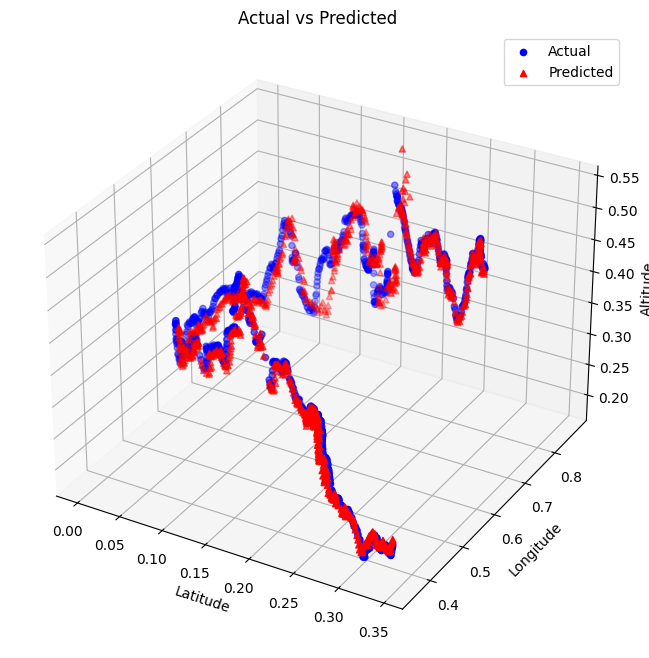

In [ ]:
prediction_visualization(y_true, y_pred)

Todo
- min max scaling 풀어서, raw랑 찍어보기
- epoch이랑 batch, learning rate 찍어보기
- 파라미터 수 측정
- 모델 구조 출려 코드

#### 3. raw 데이터와 predict 데이터 비교

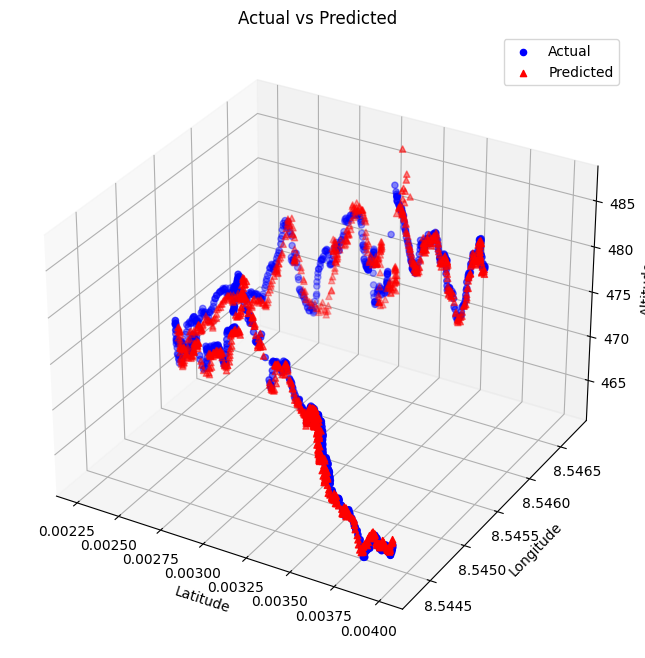

In [ ]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

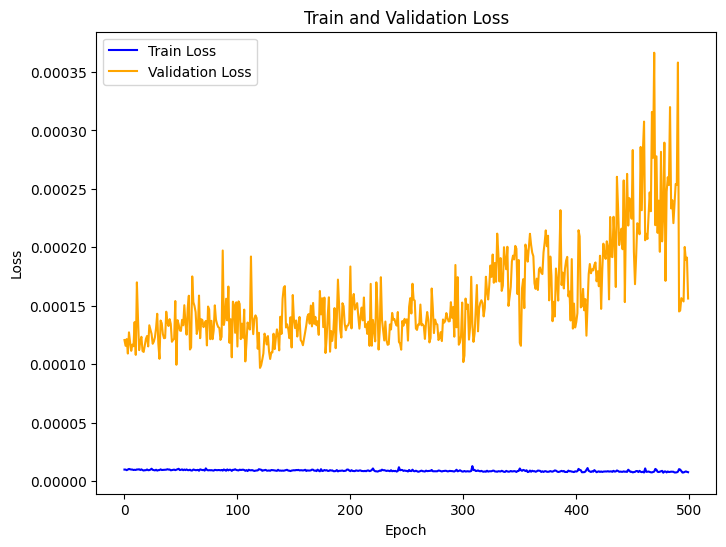

In [ ]:
import matplotlib.pyplot as plt

# 학습 후 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 기타

In [ ]:
# # 최적의 하이퍼파라미터로 모델 학습 및 평가
# def train_and_evaluate(best_params, num_epochs=50):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

#     # 첫 번째 배치로 input/output 크기 결정
#     first_batch = next(iter(train_loader))
#     input_size = first_batch[0].shape[2]
#     output_size = first_batch[1].shape[1]

#     # 모델 초기화
#     model = GRUModel(input_size, best_params['n_units_l0'], output_size, best_params['n_layers'], best_params['dropout']).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

#     # 학습 및 검증 기록
#     history = {'train_loss': [], 'val_loss': []}

#     start_time = time.time() # 학습 시작 시간 기록

#     for epoch in range(num_epochs):
#         train_loss = train_model(model, criterion, optimizer, train_loader, device)
#         val_loss, _, _ = evaluate_model(model, criterion, val_loader, device)
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     end_time = time.time()
#     total_training_time = end_time - start_time

#     print(f"Total Training Time: {total_training_time:.2f} seconds")

#     return model, history

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # 학습 중 기록된 train_loss와 val_loss 그래프 그리기
    epochs = len(history['train_loss'])  # 기록된 에포크 수
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.plot(range(epochs), history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_loss(best_model.history)

AttributeError: 'GRUModel' object has no attribute 'history'

Total Inference Time: 0.37 seconds
Test Loss: 0.0001


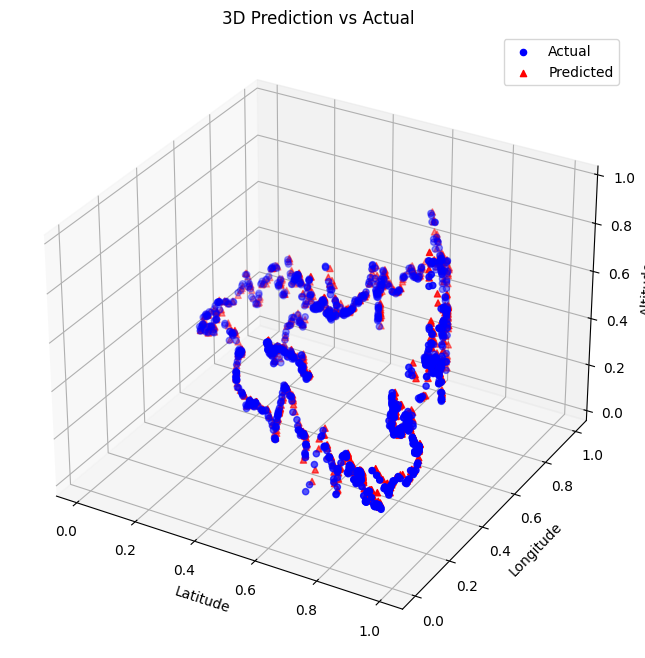

In [ ]:
# # 테스트 데이터 평가
# train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

# test_loss, true_values, predictions = evaluate_model(model, nn.MSELoss(), test_loader, 'cpu')
# print(f"Test Loss: {test_loss:.4f}")

# prediction_visualization(true_values, predictions)

In [ ]:
# !pip install torchinfo

# from torchinfo import summary

# summary(model, (1, 10, 3), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 109]              109,218
├─Linear: 1-2                            [1, 3]                    330
Total params: 109,548
Trainable params: 109,548
Non-trainable params: 0
Total mult-adds (M): 1.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45

In [ ]:
X_test.shape, y_test.shape

((1082, 10, 3), (1082, 3))

In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # 예시로 X_test와 y_test가 이렇게 생겼다고 가정
# X_test = np.random.rand(1082, 10, 3)
# y_test = np.random.rand(1082, 3)

# # min_max_scaler가 이미 학습되어 있다고 가정합니다.
# # 예시: min_max_scaler.fit(train_data)

# # X_test와 y_test를 원래 스케일로 되돌리기 위한 함수
# def inverse_min_max_scaling_X_y(X_test, y_test, scaler):
#     # 3D 데이터를 2D로 변경 (샘플 수 * 시퀀스 길이, feature)
#     X_test_2D = X_test.reshape(-1, X_test.shape[2])

#     # X_test 역변환 (스케일러는 feature 단위로 동작)
#     X_test_original = scaler.inverse_transform(X_test_2D)

#     # 다시 3D로 reshape (원래 형태로 복구)
#     X_test_original = X_test_original.reshape(X_test.shape)

#     # y_test는 2D이므로 바로 역변환
#     y_test_original = scaler.inverse_transform(y_test)

#     return X_test_original, y_test_original

# # 원래 스케일로 변환
# X_test_original, y_test_original = inverse_min_max_scaling_X_y(X_test, y_test, min_max_scaler)

# # 결과 확인
# print("Original X_test shape:", X_test_original.shape)
# print("Original y_test shape:", y_test_original.shape)


Original X_test shape: (1082, 10, 3)
Original y_test shape: (1082, 3)
